# IMDB 리뷰 감성 분류 - RNN 모델

## 라이브러리 임포트

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 로드

In [ ]:
DATA_PATH = '/content/drive/MyDrive/nlpdata/imdb/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [ ]:
train_input = np.load(open(DATA_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_PATH + DATA_CONFIGS, 'r'))

## 모델 하이퍼파라메터 정의

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.2
MAX_LEN = train_input.shape[1]

kargs = {'model_name': 'rnn_classifier',
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_dimension': 100,
        'dropout_rate': 0.2,
        'lstm_dimension': 150,
        'dense_dimension': 150,
        'output_dimension':1}

## 모델 구현

In [ ]:
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['dense_dimension'],
                           activation=tf.keras.activations.tanh)
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [ ]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
checkpoint_path = DATA_PATH + '/weights_rnn.h5'
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 개선이 없으면 종료)
es = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
mc = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, 
                     save_best_only=True, save_weights_only=True)

In [ ]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[es, mc])

Epoch 1/5
157/157 [==============================] - 51s 109ms/step - loss: 0.6933 - accuracy: 0.4970 - val_loss: 0.6927 - val_accuracy: 0.5166

Epoch 00001: val_accuracy improved from -inf to 0.51660, saving model to /content/drive/MyDrive/nlpdata/imdb/weights_rnn.h5
Epoch 2/5
157/157 [==============================] - 16s 103ms/step - loss: 0.6928 - accuracy: 0.5002 - val_loss: 0.6919 - val_accuracy: 0.5172

Epoch 00002: val_accuracy improved from 0.51660 to 0.51720, saving model to /content/drive/MyDrive/nlpdata/imdb/weights_rnn.h5
Epoch 3/5
157/157 [==============================] - 16s 103ms/step - loss: 0.6527 - accuracy: 0.5632 - val_loss: 0.3367 - val_accuracy: 0.8568

Epoch 00003: val_accuracy improved from 0.51720 to 0.85680, saving model to /content/drive/MyDrive/nlpdata/imdb/weights_rnn.h5
Epoch 4/5
157/157 [==============================] - 16s 103ms/step - loss: 0.2898 - accuracy: 0.8881 - val_loss: 0.2942 - val_accuracy: 0.8836

Epoch 00004: val_accuracy improved from 0.

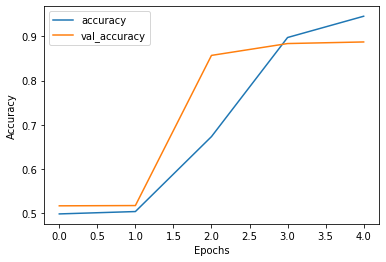

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## 테스트 데이터 불러오기

In [ ]:
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

## 베스트 모델 불러오기

In [ ]:
model.load_weights(os.path.join(DATA_PATH, 'weights_rnn.h5'))

## 테스트 데이터 예측하기

In [ ]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [ ]:
test_id = np.load(open(DATA_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

output = pd.DataFrame(data={"id": list(test_id), "sentiment":list(predictions)})
output.to_csv(DATA_PATH + 'answer_rnn.csv', index=False, quoting=3)

## kgggle에 결과 제출 및 스코어 확인
- https://www.kaggle.com/c/word2vec-nlp-tutorial|